In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
import nltk
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader_model = SentimentIntensityAnalyzer()
import spacy
from sklearn import metrics
from matplotlib import pyplot as plt
import numpy as np
import pickle
nlp = spacy.load('en')


In [4]:
data = pd.read_csv("../../mbti_1.csv")

In [5]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

# Preprocessing text

In [6]:

stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True):
    
    data['pp_post']=None

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if i % 500 == 0:
            print("%s | %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
                
        row[1].pp_post = temp
    return data

data_new = pre_process_data(data, remove_stop_words=True)

500 | 8675 rows
1000 | 8675 rows
1500 | 8675 rows
2000 | 8675 rows
2500 | 8675 rows
3000 | 8675 rows
3500 | 8675 rows
4000 | 8675 rows
4500 | 8675 rows
5000 | 8675 rows
5500 | 8675 rows
6000 | 8675 rows
6500 | 8675 rows
7000 | 8675 rows
7500 | 8675 rows
8000 | 8675 rows
8500 | 8675 rows


In [8]:
data_new

,type,posts,pp_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,link link enfp intj moment link sportscenter ...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positio...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one link course say know blessing curse ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric g...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching...
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,link ixfp always think cat fi doms reason lin...
8671,ENFP,'So...if this thread already exists someplace ...,thread already exists someplace else link pos...
8672,INTP,'So many questions when i do these things. I ...,many question thing would take purple pill pi...
8673,INFP,'I am very conflicted right now when it comes ...,conflicted right come wanting child honestly ...


# Wordcloud using TFIDF 

In [10]:
ngrams,categ = 1,"ISFJ"
corpus = data_new['pp_post'].values # get for all possible categories
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(ngrams,ngrams))
vecs = vectorizer.fit_transform(corpus)

In [11]:
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

In [52]:
# with open("all_df.pkl","wb") as p:
#     pickle.dump(df,p, protocol=4)

In [48]:
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=120).generate_from_frequencies(df.T.sum(axis=1))

(-0.5, 799.5, 399.5, -0.5)

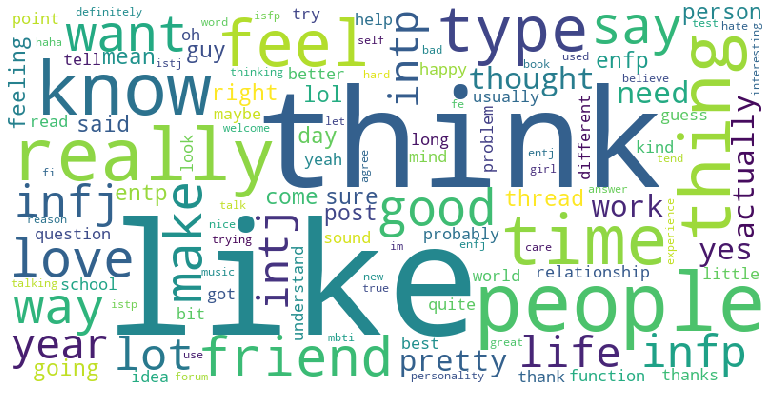

In [49]:
plt.figure( figsize=(14,7) )
plt.imshow(wordcloud)
plt.axis('off')

# Sentiment Analysis

In [14]:
def run_vader(textual_unit, 
              lemmatize=False, 
              parts_of_speech_to_consider=set(),
              verbose=0):
    
    """
    Generates a dictionary of sentiment scores
    """

    doc = nlp(textual_unit)
        
    input_to_vader = []

    for sent in doc.sents:
        for token in sent:

            to_add = token.text

            if lemmatize:
                to_add = token.lemma_

                if to_add == '-PRON-': 
                    to_add = token.text

            if parts_of_speech_to_consider:
                if token.pos_ in parts_of_speech_to_consider:
                    input_to_vader.append(to_add) 
            else:
                input_to_vader.append(to_add)

    scores = vader_model.polarity_scores(' '.join(input_to_vader))
    
    if verbose >= 1:
        print()
        print('INPUT SENTENCE', sent)
        print('INPUT TO VADER', input_to_vader)
        print('VADER OUTPUT', scores)

    return scores

In [55]:
def get_sentiment_of_sentence(sent):
    
    """
    Returns sentiment for a particular sentence
    """
    
    sentiment_dict = run_vader(sent)
    if sentiment_dict['compound'] >= 0.05 : 
        return "Positive" 
    elif sentiment_dict['compound'] <= - 0.05 : 
        return "Negative"
    else : 
        return "Neutral"
    
result_dict = {categ: {"Positive":0, "Negative":0, "Neutral":0} for categ in data['type'].unique()}

def get_sentiments(df):
    
    """
    Creates result_dict that contains number of positive, negative and neutral sentiments for each personality type
    """
    
    for i,row in df.iterrows():
        categ = row['type']
        post = row['posts']
        post_nolinks = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '<LINK>', post)
        postsplit = post_nolinks.split("|||")
        for comment in postsplit:
            sentiment = get_sentiment_of_sentence(comment.strip())
            result_dict[categ][sentiment] += 1        
        if i%50==0:
            print("%s rows done"%i)
        
get_sentiments(data)

In [19]:
result_dict

{'INFJ': {'Positive': 42642, 'Negative': 17082, 'Neutral': 12381},
 'ENTP': {'Positive': 18771, 'Negative': 8629, 'Neutral': 6361},
 'INTP': {'Positive': 33467, 'Negative': 16982, 'Neutral': 12910},
 'INTJ': {'Positive': 28237, 'Negative': 13870, 'Neutral': 10364},
 'ENTJ': {'Positive': 6358, 'Negative': 2895, 'Neutral': 2020},
 'ENFJ': {'Positive': 5981, 'Negative': 2013, 'Neutral': 1294},
 'INFP': {'Positive': 51933, 'Negative': 21907, 'Neutral': 15956},
 'ENFP': {'Positive': 20989, 'Negative': 7108, 'Neutral': 4672},
 'ISFP': {'Positive': 7522, 'Negative': 2824, 'Neutral': 2654},
 'ISTP': {'Positive': 8608, 'Negative': 4423, 'Neutral': 3467},
 'ISFJ': {'Positive': 4870, 'Negative': 1805, 'Neutral': 1446},
 'ISTJ': {'Positive': 5515, 'Negative': 2457, 'Neutral': 1941},
 'ESTP': {'Positive': 2392, 'Negative': 1075, 'Neutral': 870},
 'ESFP': {'Positive': 1224, 'Negative': 492, 'Neutral': 499},
 'ESTJ': {'Positive': 1102, 'Negative': 447, 'Neutral': 372},
 'ESFJ': {'Positive': 1289, 'Ne

In [41]:
#Dump the dictionary into a pickle file
with open("result_dict.pkl","wb") as p:
    pickle.dump(result_dict,p)

In [2]:
#Load the dictionary from the pickle file
with open("result_dict.pkl","rb") as p:
    result_dict = pickle.load(p)

/Users/kaustavdatta/Downloads/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


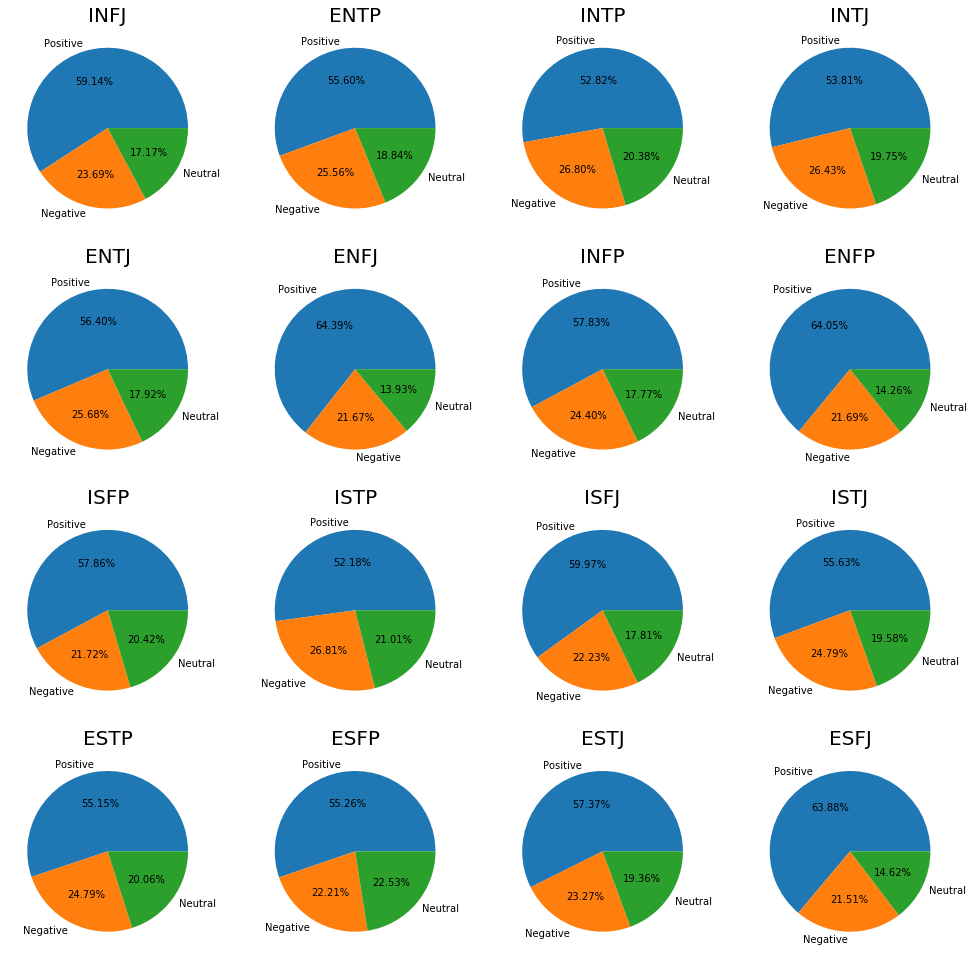

In [3]:
#Plot pie charts, showing percentage of each sentiment type for each personality type
fig, ax = plt.subplots(4, 4, figsize=(17,17))
i,j=0,0
for key, value in result_dict.items():
    sentiment_labels = list(value.keys())
    counts = list(value.values())
    ax[i][j].pie(counts, labels = sentiment_labels,autopct='%1.2f%%')
    ax[i][j].set_title(key, fontsize=20)
    fig.show()
    j+=1    
    if j==4:
        i+=1
        j=0
